## Import Libraries


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
from tqdm import tqdm
from imblearn.over_sampling import SMOTE

## Data Preprocessing

In [2]:
wq_data = pd.read_csv("water_potability.csv")
print("Number of entries: ", wq_data.shape[0])
print("Number of columns: ", wq_data.shape[1])

Number of entries:  3276
Number of columns:  10


Target value is 'Potability' column, the rest of them are going to be features. Potability shows if water is safe for human consumption where 1: potable (safe) and 0: not potable.

In [3]:
list(wq_data.columns)

['ph',
 'Hardness',
 'Solids',
 'Chloramines',
 'Sulfate',
 'Conductivity',
 'Organic_carbon',
 'Trihalomethanes',
 'Turbidity',
 'Potability']

The dataset contains missing values in three columns: ph, Sulfate, and Trihalomethanes. Instead of just dropping missing values, let's impute median, since all the values are continuous variables. However, we will do it a little bit later.

In [4]:
missing_values = wq_data.isnull().sum()
missing_values, "--------------------", wq_data.dtypes

(ph                 491
 Hardness             0
 Solids               0
 Chloramines          0
 Sulfate            781
 Conductivity         0
 Organic_carbon       0
 Trihalomethanes    162
 Turbidity            0
 Potability           0
 dtype: int64,
 '--------------------',
 ph                 float64
 Hardness           float64
 Solids             float64
 Chloramines        float64
 Sulfate            float64
 Conductivity       float64
 Organic_carbon     float64
 Trihalomethanes    float64
 Turbidity          float64
 Potability           int64
 dtype: object)

## Exploratory Data Analysis

- Summary statistics.
- Distribution of features.
- Correlation analysis.

In [5]:
#basic information
print(wq_data.describe())

                ph     Hardness        Solids  Chloramines      Sulfate  \
count  2785.000000  3276.000000   3276.000000  3276.000000  2495.000000   
mean      7.080795   196.369496  22014.092526     7.122277   333.775777   
std       1.594320    32.879761   8768.570828     1.583085    41.416840   
min       0.000000    47.432000    320.942611     0.352000   129.000000   
25%       6.093092   176.850538  15666.690297     6.127421   307.699498   
50%       7.036752   196.967627  20927.833607     7.130299   333.073546   
75%       8.062066   216.667456  27332.762127     8.114887   359.950170   
max      14.000000   323.124000  61227.196008    13.127000   481.030642   

       Conductivity  Organic_carbon  Trihalomethanes    Turbidity   Potability  
count   3276.000000     3276.000000      3114.000000  3276.000000  3276.000000  
mean     426.205111       14.284970        66.396293     3.966786     0.390110  
std       80.824064        3.308162        16.175008     0.780382     0.487849  


The distribution of data classes is slightly unbalanced. We see that about 60% of samples are labeled 0 Not Potable and 40% as Potable (1). This imbalance can imply:
- Bias towards majority class
- The minority class (class 1) might be under-represented in the model's training process, leading to less reliable predictions for that class.
- Traditional accuracy metrics might be misleading.

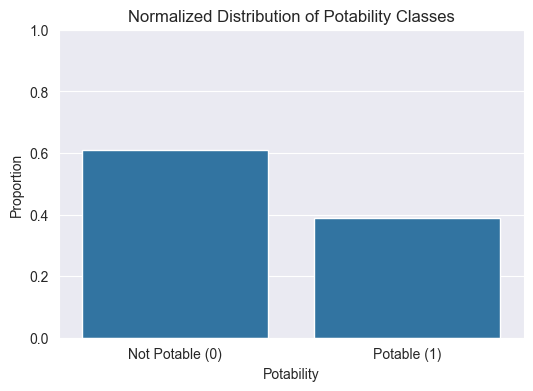

In [6]:
class_counts = wq_data['Potability'].value_counts(normalize=True)

plt.figure(figsize=(6, 4))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Normalized Distribution of Potability Classes')
plt.xlabel('Potability')
plt.ylabel('Proportion')
plt.ylim(0, 1)  # Setting scale from 0 to 1
plt.xticks([0, 1], ['Not Potable (0)', 'Potable (1)'])  # Renaming x-ticks for clarity
plt.show()

Using heatmap to visualize the correlations between different features can help to reveal which features are strongly correlated with Potability.


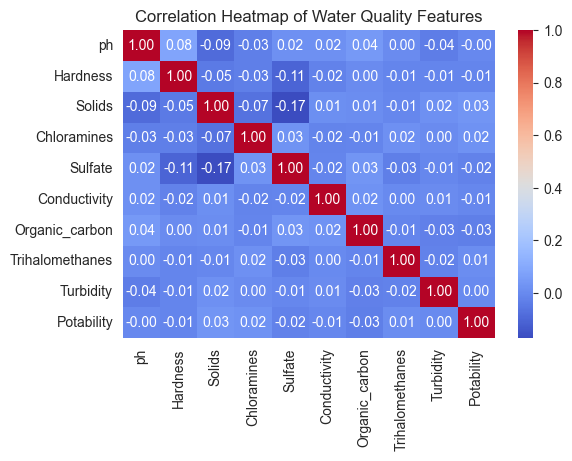

In [7]:
corr_matrix = wq_data.corr()

plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Water Quality Features')
plt.show()

From the Heatmap we can see that there is no strong correlation between features and target Potability. In general, most features have low to moderate correlations with each other.
To reveal more complex, non-linear relationships between features we will use machine learning models.

## Data Preprocessing for Modeling

From preprocessing our dataset, we already have seen that there are quite some amount of missing values. If we impute missing values using the entire dataset before splitting into training and testing sets, we inadvertently introduce information from the test set into the training process. This is because the imputation process would use data (our mean) that is calculated from the entire dataset, influencing the imputed values in the training set. To avoid this, we first split our data. Calculate imputation values (mean) only from the training set.

In [8]:
X = wq_data.drop('Potability', axis=1)
y = wq_data['Potability']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# impute missing values in training set
imputer = SimpleImputer(strategy="median")
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)  #'transform' and not 'fit_transform'

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)  # ! only 'transform' is used

In [9]:
print("Training set (X_train, y_train):", X_train.shape, y_train.shape)
print("Test set (X_test, y_test):", X_test.shape, y_test.shape)

Training set (X_train, y_train): (2620, 9) (2620,)
Test set (X_test, y_test): (656, 9) (656,)


## Model Development
- Logistic Regression
- Decision Tree Classifier
- Random Forest Classifier
- Gradient Boosting Classifier
- Support Vector Machine (SVM)
- K-Nearest Neighbors (KNN)

In [10]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "SVM": SVC(probability=True),
    "KNN": KNeighborsClassifier()}

In [11]:
def train_evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
    roc_auc = roc_auc_score(y_test, y_prob)
    return accuracy, precision, recall, f1, roc_auc

In [12]:
performance = {}
for name, model in tqdm(models.items(), desc="Training Models"):
    performance[name] = train_evaluate_model(model, X_train_scaled, y_train, X_test_scaled, y_test)

Training Models:   0%|          | 0/6 [00:00<?, ?it/s]C:\Users\plani\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training Models: 100%|██████████| 6/6 [00:05<00:00,  1.10it/s]


In [13]:
performance_df = pd.DataFrame(performance, index=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC'])

### Dealing with unbalanced dataset
We have seen that labels distribution a little bit not proportional: 60% of data entries labeled as 'not potable' (0). To mitigate this issue, we will generate synthetic samples for the minority class (SMOTE)

In [14]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

In [15]:
X_train_balanced, y_train_balanced = X_train_smote, y_train_smote

performance_balanced = {}
for name, model in tqdm(models.items(), desc="Training Models"):
    performance_balanced[name] = train_evaluate_model(model, X_train_balanced, y_train_balanced, X_test_scaled, y_test)

performance_df_balanced = pd.DataFrame(performance_balanced, index=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC'])

Training Models: 100%|██████████| 6/6 [00:06<00:00,  1.14s/it]


## Model Evaluation
We'll evaluate each model using metrics suitable for classification tasks, such as:

Accuracy
Precision, Recall, and F1-Score
ROC-AUC Score

In [16]:
# dictionary for each metric
top_3_models_per_metric = {}

for metric in performance_df.index:
    # sort the top 3
    top_models = performance_df.T.sort_values(by=metric, ascending=False).head(3)
    top_3_models_per_metric[metric] = top_models[[metric]]

for metric, df in top_3_models_per_metric.items():
    print(f"Top 3 Models based on {metric}:")
    print(df, '\n')

Top 3 Models based on Accuracy:
                   Accuracy
SVM                0.690549
Random Forest      0.673780
Gradient Boosting  0.661585 

Top 3 Models based on Precision:
                   Precision
SVM                 0.678261
Gradient Boosting   0.607843
Random Forest       0.600000 

Top 3 Models based on Recall:
                 Recall
Decision Tree  0.475410
KNN            0.418033
Random Forest  0.368852 

Top 3 Models based on F1 Score:
               F1 Score
Decision Tree  0.457594
Random Forest  0.456853
KNN            0.456376 

Top 3 Models based on ROC AUC:
                    ROC AUC
Random Forest      0.695473
SVM                0.685008
Gradient Boosting  0.653952 



In [17]:
# same but for balanced data (after SMOTE)
top_3_models_balanced = {}

for metric in performance_df_balanced.index:
    top_models_balanced = performance_df_balanced.T.sort_values(by=metric, ascending=False).head(3)
    top_3_models_balanced[metric] = top_models_balanced[[metric]]

for metric, df in top_3_models_balanced.items():
    print(f"Top 3 Models (balanced) based on {metric}:")
    print(df, '\n')

Top 3 Models (balanced) based on Accuracy:
                   Accuracy
Random Forest      0.653963
SVM                0.635671
Gradient Boosting  0.608232 

Top 3 Models (balanced) based on Precision:
                   Precision
Random Forest       0.534694
SVM                 0.509091
Gradient Boosting   0.475096 

Top 3 Models (balanced) based on Recall:
                 Recall
KNN            0.577869
SVM            0.573770
Random Forest  0.536885 

Top 3 Models (balanced) based on F1 Score:
               F1 Score
SVM            0.539499
Random Forest  0.535787
KNN            0.521257 

Top 3 Models (balanced) based on ROC AUC:
                    ROC AUC
SVM                0.689191
Random Forest      0.683894
Gradient Boosting  0.662940 



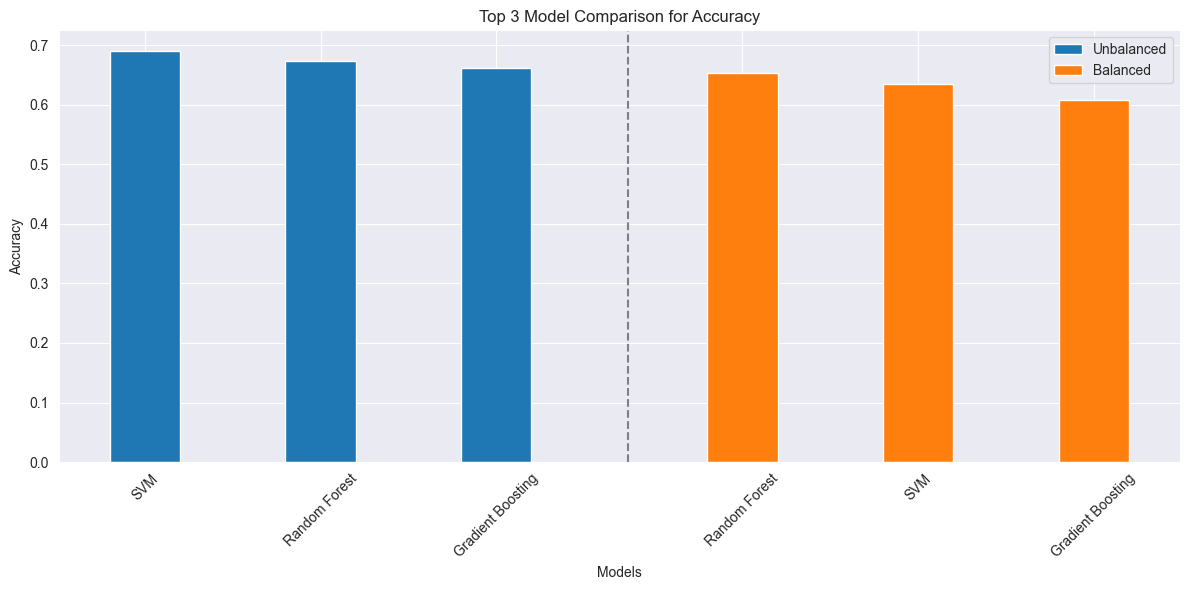

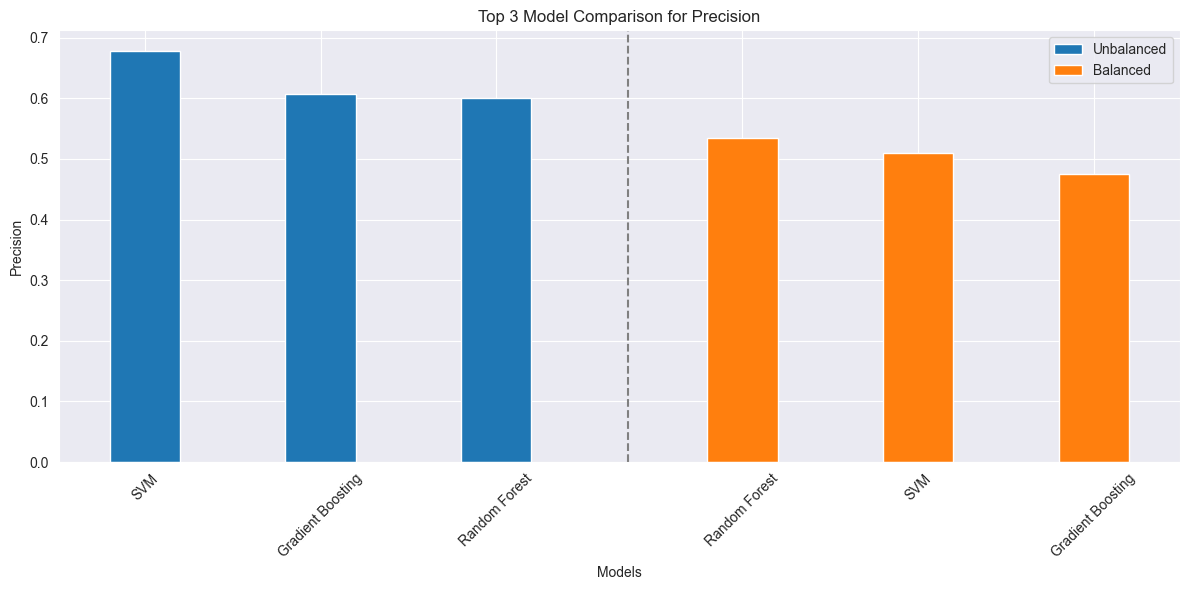

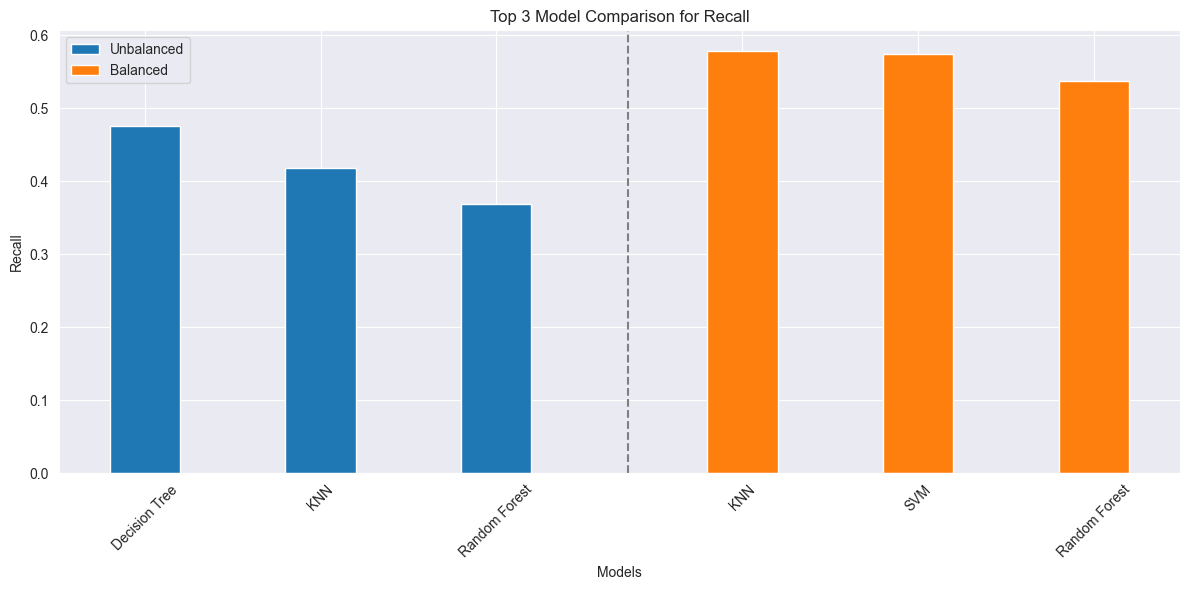

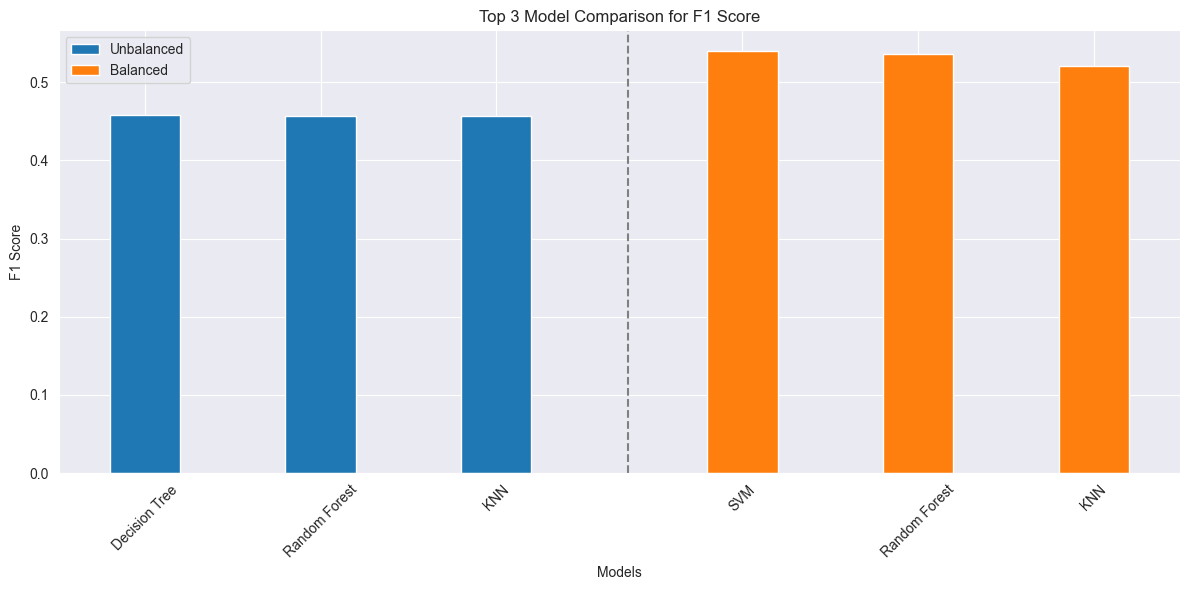

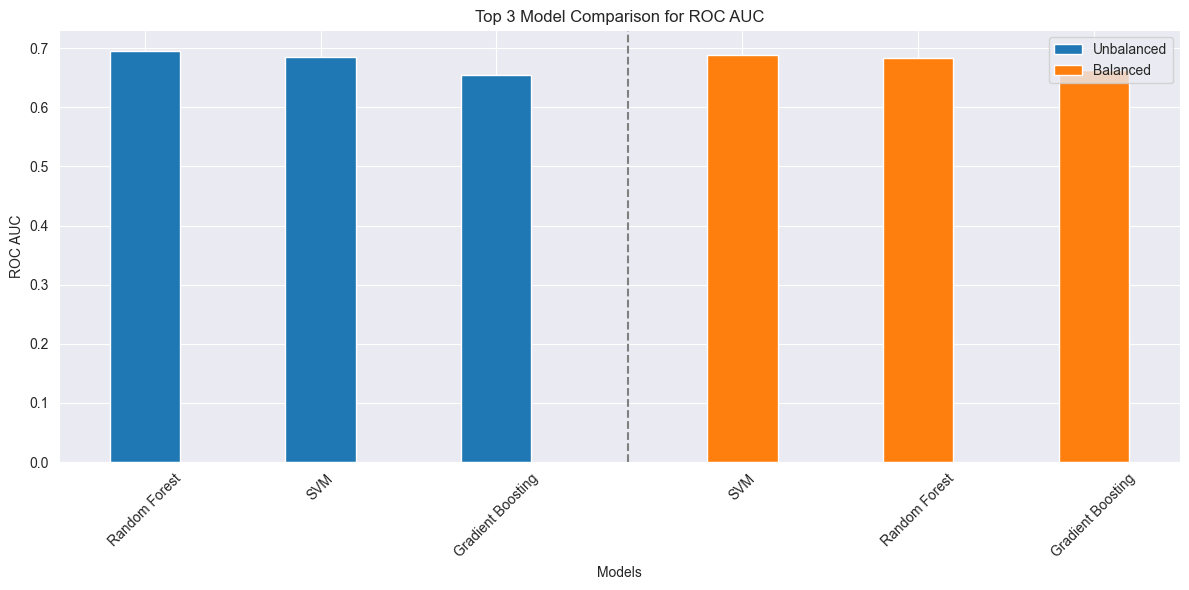

In [18]:
for metric in performance_df.index:
    plt.figure(figsize=(12, 6))

    unbalanced_data = top_3_models_per_metric[metric].reset_index()
    balanced_data = top_3_models_balanced[metric].reset_index()

    # Number of models (top 3 for each dataset)
    n_models = 3

    # Create positions for each group of bars
    total_width = 0.4  # width for each group (unbalanced and balanced)
    unbalanced_positions = np.arange(n_models)
    balanced_positions = np.arange(n_models) + n_models + total_width  # Offset for the second group

    plt.bar(unbalanced_positions, unbalanced_data[metric], width=total_width, label='Unbalanced')
    plt.bar(balanced_positions, balanced_data[metric], width=total_width, label='Balanced')

    plt.axvline(x=2.75, color='grey', linestyle='--') # separation line

    plt.xlabel('Models')
    plt.ylabel(metric)
    plt.title(f'Top 3 Model Comparison for {metric}')
    plt.xticks(np.concatenate([unbalanced_positions, balanced_positions]),
               np.concatenate([unbalanced_data['index'], balanced_data['index']]),
               rotation=45)
    plt.legend()

    plt.tight_layout()
    plt.show()

## Conclusion:

SVM and Random Forest appear consistently among the top performers across most metrics on both datasets. Their performance seems robust whether the data is balanced or not. KNN and Decision Tree perform better on recall and F1 score on the balanced dataset, suggesting they are better at identifying the minority class after balancing. Accuracy is generally higher on the unbalanced dataset, which is likely due to the models predicting the majority class more frequently.
 Balancing the dataset has impacted the models' ability to more accurately identify the minority class, as evidenced by the changes in Recall and F1 scores.
There's a clear trade-off between precision and recall when balancing the dataset, which is a common scenario in classification tasks. In summary, balancing the dataset changes the performance landscape of the models, generally improving their ability to identify the minority class at the cost of overall accuracy. The best model choice depends on the specific performance metric that is most critical for your application.